In [1]:
%pip install alpha_vantage
%pip install arch


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pair_trading_foundations.utils import GetSP500Data
from arch.unitroot import engle_granger, ADF
from alpha_vantage.timeseries import TimeSeries
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import pandas as pd
import numpy as np
import warnings
# The yfinance module has some deprecation warning
warnings.filterwarnings('ignore')

/Users/michaeltay/miniforge3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  3 of 3 completed

Price        Adj Close                              Close             \
Ticker            AAPL      GOOGL        MSFT        AAPL      GOOGL   
Date                                                                   
2023-01-03  124.216293  89.120003  237.474335  125.070000  89.120003   
2023-01-04  125.497505  88.080002  227.086456  126.360001  88.080002   
2023-01-05  124.166634  86.199997  220.356125  125.019997  86.199997   
2023-01-06  128.735245  87.339996  222.953079  129.619995  87.339996   
2023-01-09  129.261627  88.019997  225.123840  130.149994  88.019997   

Price                         High                                Low  \
Ticker            MSFT        AAPL      GOOGL        MSFT        AAPL   
Date                                                                    
2023-01-03  239.580002  130.899994  91.050003  245.750000  124.169998   
2023-01-04  229.100006  128.660004  90.650002  232.869995  125.080002   
2023-01-05  222.309998  127.769997  87.570000  227.550003 

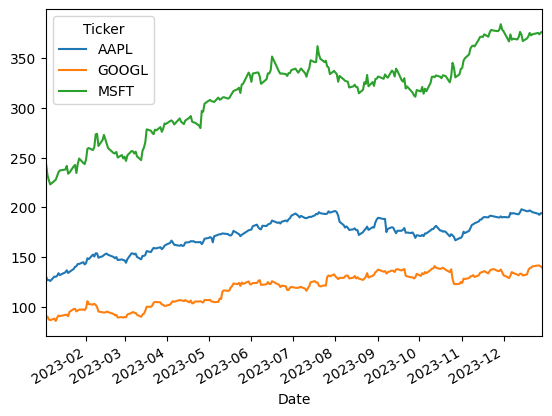

In [3]:
def get_sp500_symbols():
    sp500_symbols = ['AAPL', 'MSFT', 'GOOGL']  # Have feed list of S&P 500 component symbols
    return sp500_symbols

if __name__ == '__main__':
    # get all stock info interested
    data_frame = pdr.get_data_yahoo(get_sp500_symbols(), start='2023-01-01', end='2023-12-31')
    
    print(data_frame.head())

    # Filter by open prices
    regular_price = data_frame['Open']
    log_price = np.log(regular_price)
    ax = regular_price.plot()
    xl = ax.set_xlim(regular_price.index.min(), regular_price.index.max())

In [4]:
# Dicker-fuller test for APPL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.AAPL, trend="c")

Test Statistic,-2.351
P-value,0.156
Lags,0


In [5]:
# Dicker-fuller test for diff(1,APPL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.AAPL.diff(periods=1).dropna(), trend="c")

Test Statistic,-16.582
P-value,0.000
Lags,0


In [6]:
# Dicker-fuller test for GOOGL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.GOOGL, trend="c")

Test Statistic,-1.522
P-value,0.523
Lags,0


In [7]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.GOOGL.diff(periods=1).dropna(), trend="c")

Test Statistic,-15.492
P-value,0.000
Lags,0


In [8]:
# Dicker-fuller test for MSFT, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.MSFT, trend="c")

Test Statistic,-2.151
P-value,0.225
Lags,4


In [9]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.MSFT.diff(periods=1).dropna(), trend="c")

Test Statistic,-13.422
P-value,0.000
Lags,1


In [10]:
# Michael: APPL & MSFT looks cointegrated, p-value < 0.05, but fail the ADF test
eg_test = engle_granger(log_price.AAPL.diff(periods=1).dropna(), log_price.MSFT.diff(periods=1).dropna(), trend="n")
eg_test

Test Statistic,-16.900
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.072


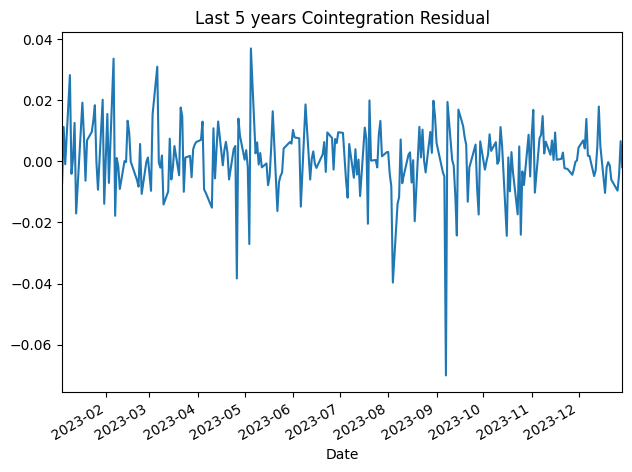

In [11]:
# Michael: Plot the residuals for cointegration 
fig = eg_test.plot()
ax = fig.get_axes()[0]
title = ax.set_title("Last 5 years Cointegration Residual")

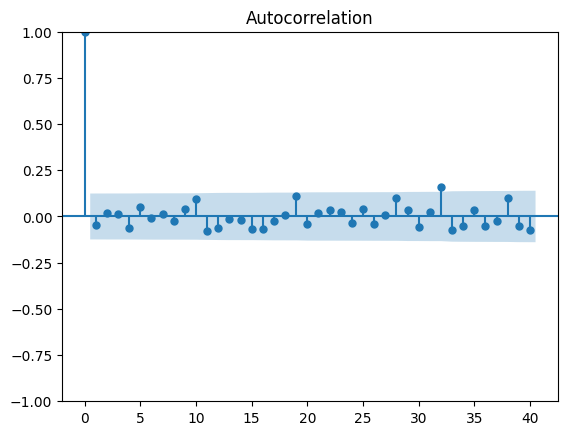

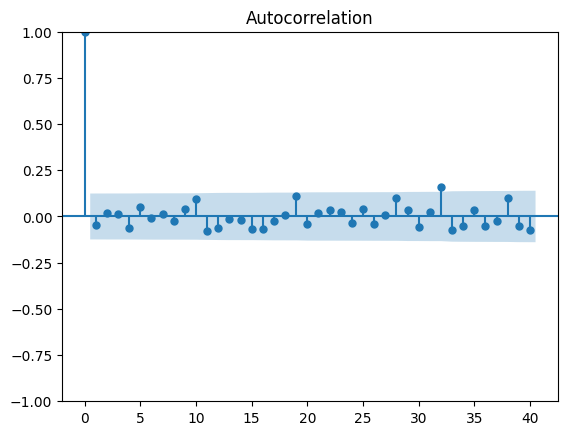

In [12]:
# Let's pick AAPL
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(log_price.AAPL.diff(periods=1).dropna(), lags=40)

In [13]:
df = pd.DataFrame(log_price.AAPL)
df.columns=["LogPrice"]
df

,LogPrice
Date,
2023-01-03,4.869686
2023-01-04,4.843321
2023-01-05,4.845210
2023-01-06,4.836361
2023-01-09,4.871143
...,...
2023-12-22,5.273922
2023-12-26,5.265846
2023-12-27,5.260044


In [14]:
# split into train and test sets
ts = log_price.AAPL
# Apply first differencing
X = ts.diff(periods=1).dropna()
# Split train/test
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [15]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,0,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  248
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 723.023
Date:                Tue, 13 Feb 2024   AIC                          -1430.045
Time:                        17:10:55   BIC                          -1401.938
Sample:                             0   HQIC                         -1418.730
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.807      0.071      -0.000       0.003
ar.L1         -0.0159      1.427     -0.011      0.991      -2.812       2.780
ar.L2          0.0129      0.082      0.158      0.8

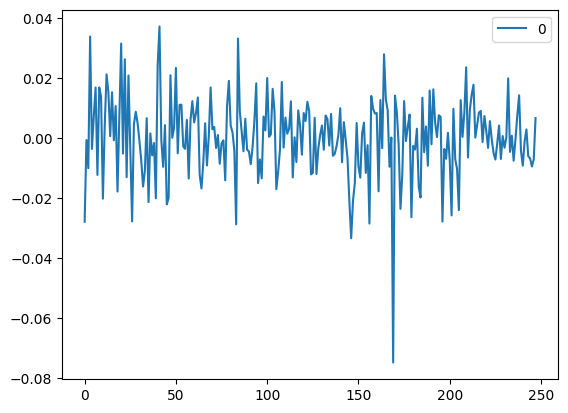

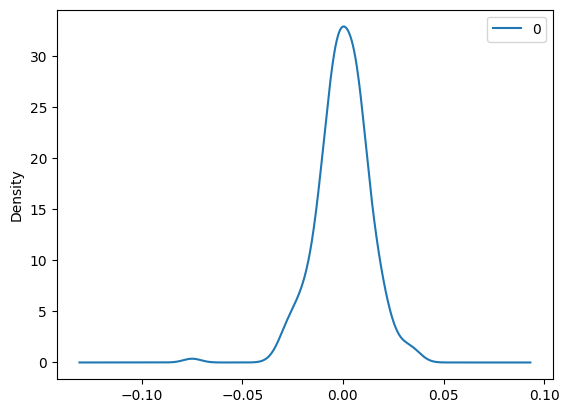

                0
count  248.000000
mean     0.000003
std      0.013138
min     -0.074873
25%     -0.007138
50%      0.000277
75%      0.007983
max      0.037098


In [16]:
from matplotlib import pyplot
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

,LogPrice,prediction
Date,,
2023-01-03,4.869686,4.871079
2023-01-04,4.843321,4.843348
2023-01-05,4.845210,4.844990
2023-01-06,4.836361,4.837225
2023-01-09,4.871143,4.870407
...,...,...
2023-12-22,5.273922,5.274139
2023-12-26,5.265846,5.266574
2023-12-27,5.260044,5.259927


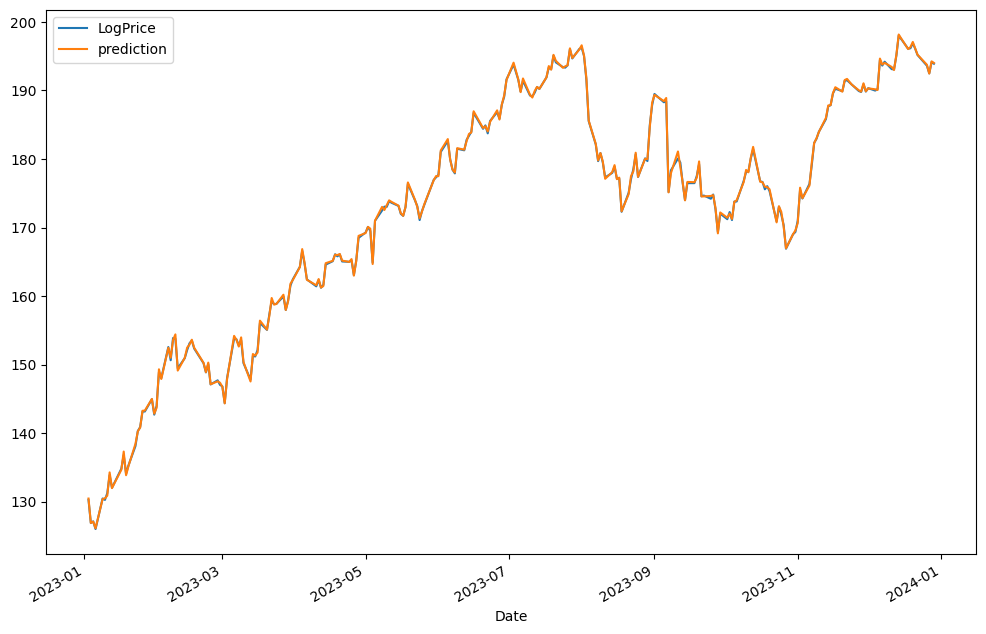

In [17]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt   

# invert differenced value
def inverse_difference(history, yhat, interval=1):
 return yhat + history[-interval]

# evaluate performance for 1 year using ARIMA
df['prediction'] = df['LogPrice'] + inverse_difference(history, model_fit.predict(start=1, end=250, dynamic=False))
# Convert to actual price
df = np.exp(df)
df.columns = ['test_age', 'test_favorite_color','test_grade', 'test_name']
np.exp(df).plot(figsize=(12,8))
df